# Motion Planning, Assignment 5: Rapidly Exploring Random Trees

#### Thao Dang, Hochschule Esslingen

<a id="fig_1"></a>
![Fig. 1: Robot scenario](https://drive.google.com/uc?export=view&id=1DWaUj5gBk9fZm9SEzFPan4VKp-cmGVwK)

In this assignment, you will search an collision-free path with an Rapidly Exploring Random Tree. The algorithm is described in the lecture slides. Please note that you will be using goal-oriented sampling.

The robot motion will be executed by a simple local planning function that allows the robot to move forward in any direction but stops when the robot encounters an obstacle.

First, the usual boilerplate code to load the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

The following defines our world including start and goal configurations. Obstacles are defined as circles with various radii. A few helper functions are given to draw the scene.

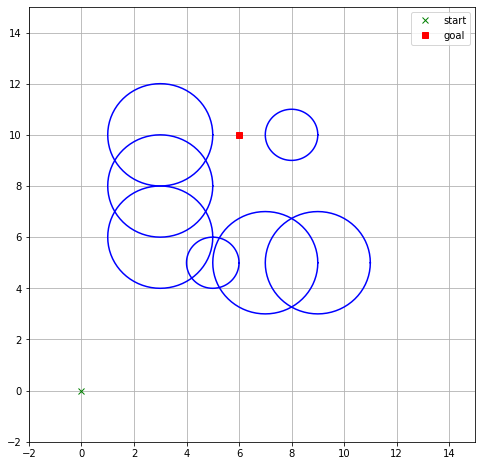

In [2]:
def plot_circle(x, y, size, color='-b'):  
    """Draw circle of radius size and center pos (x,y). 
    """
    deg = list(range(0, 360, 5))
    deg.append(0)
    xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
    yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
    plt.plot(xl, yl, color)
    
    
def plot_obstacles(obstacle_list, q_start, q_end):
    """Draw all obstacles in the scene.
    """
    for (ox, oy, size) in obstacle_list:
        plot_circle(ox, oy, size)
        
    plt.plot(q_start[0], q_start[1], 'xg', label='start')
    plt.plot(q_end[0], q_end[1], 'sr', label='goal');
    
    plt.axis([-2, 15, -2, 15])
    plt.grid(True)
    plt.legend(loc='upper right');

    
obstacle_list = [
    (5, 5, 1),
    (3, 6, 2),
    (3, 8, 2),
    (3, 10, 2),
    (7, 5, 2),
    (9, 5, 2),
    (8, 10, 1)
]  # [x, y, radius]

q_start_pos, q_end_pos = (0,0), (6,10)
    
plt.figure(figsize=(8,8))
plot_obstacles(obstacle_list, q_start_pos, q_end_pos)

## Exercise 1: Finding nearest nodes and checking collisions

Below, you will find a basic class for a node in the random tree structure. Please note that the node structure contains the position of the node, its parent, and its ``path``. The ``path`` reflects that a local planner will be used later on and stores the sampled path from the parent position to the current position of the node.

Implement two functions ``get_nearest_node_index`` and ``check_collision`` below. ``get_nearest_node_index`` shall find the index of closest known node in the graph to a given refernce position. ``check_collision``
will return ``True`` if a given positions collides with the obstacles.

More information on the syntax of these functions is given in the docstrings below. Also make sure that your code passes the tests.

In [6]:
class Node:
    """RRT Node
    
    The attributes of the class are
    * pos: the position of the node, format: tuple "(x,y)"
    * path: the sampled path of the robot from the parent position to the 
            current position, format: list of tuples "[(x,y), ...]".
            NOTE: the path shall include both the parent position 
                  "parent.pos" as well as the current positon "pos"
    * parent: the parent node, format: RRT node "node"
    """

    def __init__(self, pos, path=[], parent=None):
        self.pos = pos
        self.path = path
        self.parent = parent
        
    def __str__(self):
        """Allows printing of a node."""
        return '<' + str(self.pos) + ', path=' + str(self.path) \
            + ', parent=' + str(self.parent.pos) + '>'

        
def get_nearest_node_index(node_list, rnd_node_pos):
    """Return index of closest node to position "rnd_node_pos" in list of nodes "node_list".
    """
    # INSERT CODE HERE
    nodes = np.asarray([node.pos for node in node_list])
    dist_2 = np.sum((nodes - rnd_node_pos)**2, axis=1)
    return np.argmin(dist_2)
    # END INSERTED CODE 


def check_collision(node_pos, obstacle_list):
    """Check if "node_pos" collides with any of the obstacles in "obstacle_list".
    
    Returns "True" if a collision has been detected, "False" otherwise.
    """
    # INSERT CODE HERE
    for obstacle in obstacle_list:
        # delta = node_pos - obstacle[:2]
        # dist = np.sqrt(np.sum(delta**2))
        dist, _ = calc_distance_and_angle(Node(node_pos),Node(obstacle))
        if dist <= obstacle[2]:
            return True

    return False 
    # END INSERTED CODE 

    
def calc_distance_and_angle(from_node, to_node):
    """Compute distance and angle (in rad) from "from_node" to "to_node".
    """
    dx = to_node.pos[0] - from_node.pos[0]
    dy = to_node.pos[1] - from_node.pos[1]
    d = np.sqrt(dx ** 2 + dy ** 2)
    theta = np.arctan2(dy, dx)
    return d, theta


## tests
n1 = Node((1,1), path=[(0,0), (0.3,0.3), (0.6,0.6), (1,1)], parent=None)
n2 = Node((2,2), path=[(1,1), (1.3,1.3), (1.6,1.6), (2,2)], parent=n1)
n3 = Node((8,8), path=[(2,2), (4,4), (6,6), (8,8)], parent=n2)
n4 = Node((6,6), path=[(2,2), (3,3), (4,4), (5,5), (6,6)], parent=n2)
rnd_node_pos = (3,2)
node_list = [n1, n2, n3, n4]

assert get_nearest_node_index(node_list, rnd_node_pos)==1

assert check_collision(n1.pos, obstacle_list)==False
assert check_collision(n4.pos, obstacle_list)==True

assert calc_distance_and_angle(n1, n2)==(np.sqrt(2), np.pi/4.0)


## Excercise 2: Local planner

The core of the RRT is the local planner. We assume that in each step, the robot can move forward
* in a given direction ``theta`` and 
* at most about a length ``stepSize*numSteps``.

The local planner will move the robot from a given start node ``from_node`` towards a desired node ``to_node``. While moving forward, it will check for collisions at every distance increment ``stepSize``. When a collision is detected, the robot will remain at its last valid position and the function will return a corresponding node.

When the robot reaches a distance to the desired node ``to_node`` that is below ``stepSize``, the robot shall move to the desired position and return a corresponding node.

Implement the function below and also add some tests when the local planner shall stop in front of an obstacle.

In [4]:
def local_planner(from_node, to_node, obstacle_list, stepSize=0.33, numSteps=3):
    """ Local planner function. 
    
    Arguments:
        * from_node: the start node (type: class Node)
        * to_node: the target node (type: class Node)
        * obstacle_list: the circular obstacles in the scene (type: [(x,y,r), ...])
        * stepSize: the robot should move about this distance for "numSteps" times 
            and check collisions on each individual step (type: float)
        * numSteps: the number of steps to make (type: int)
        
    Returns:
        The resulting new node (type: class Node). Note that the robot shall move **exactly** 
        to the desired node if the distance between the robot and "to_node" is below "stepSize".
    """

    new_node = Node(from_node.pos, path=[from_node.pos], parent=from_node)
    
    # INSERT CODE HERE
    for _ in range(numSteps):
        if not(check_collision(new_node.pos, obstacle_list)):
            dist, theta = calc_distance_and_angle(new_node, to_node)
            x = new_node.pos[0]+(stepSize if dist > stepSize else dist)*np.cos(theta)
            y = new_node.pos[1]+(stepSize if dist > stepSize else dist)*np.sin(theta)
            #new_node.parent = new_node
            new_node.pos = (x,y)
            new_node.path.append(new_node.pos)
    return new_node
    # END INSERTED CODE 


q_new = local_planner(n1, n2, obstacle_list, stepSize=0.5, numSteps=3)
assert q_new.pos == n2.pos
assert q_new.path[0] == n1.pos
assert q_new.path[-1] == n2.pos
assert len(q_new.path) == 4

## Excercise 2: Local planner

Using all the helper functions defined above, implement a goal oriented RRT as described in the lecture notes.

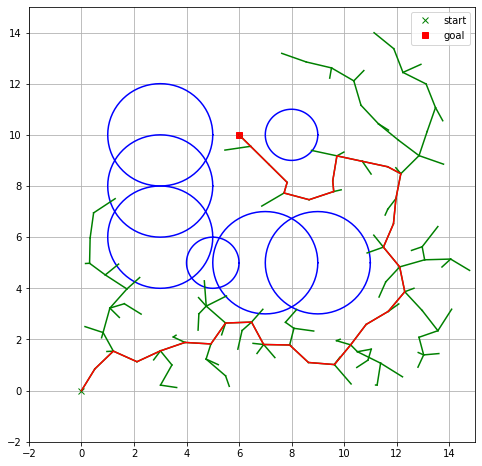

In [15]:
def draw_graph(node_list, result_path=None):
    """Draws the graph and found path.
    """
    for node in node_list:
        path_x, path_y = zip(*node.path)
        plt.plot(path_x, path_y, '-g')
        
    if result_path:
        path_x, path_y = zip(*result_path)
        plt.plot(path_x, path_y, '-r')
        

def RRT(q_start_pos, q_end_pos, obstacle_list, goal_sampling_rate=0.1, worldSize=(15,15), maxIter=1000):
    """ Goal oriented RRT. 
    
    Arguments:
        * q_start_pos: the start position (type: tuple (x,y))
        * q_end_pos: the goal position (type: tuple (x,y))
        * obstacle_list: the circular obstacles in the scene (type: [(x,y,r), ...])
        * goal_sampling_rate: the rate with which the goal position is drawn as a 
            new desired node (type: float)
        * worldSize: the size of the world used for sampling new positons (type: tuple (max_x,max_y))
        * maxIter: the maximum number of iterations used in the RRT algorithm (type: int)
        
    Returns:
        * path: the path from start to goal ("None" if none was found, a list of positions 
            [(x,y), ...] otherwise.
        * node_list: the list of nodes that forms the random tree (type: [class Node])   
    """

    
    # INSERT CODE HERE
    q_start = Node(q_start_pos, path=[q_start_pos], parent=None)
    node_list = [q_start]

    for _ in range(maxIter):
        if np.random.rand() < goal_sampling_rate:
            rnd_node_pos = q_end_pos
        else:
            rnd_node_pos = (np.random.rand()*worldSize[0], np.random.rand()*worldSize[1])
        q_nearest = node_list[get_nearest_node_index(node_list, rnd_node_pos)]
        q_new = local_planner(q_nearest, Node(rnd_node_pos), obstacle_list)
        if q_new.pos != q_nearest.pos:
            node_list.append(q_new)
        
        if q_new.pos == q_end_pos:
            path = [q_new.pos]
            while q_new.parent is not None:
                q_new = q_new.parent
                path.append(q_new.pos)
            return path[::-1], node_list

    return None, node_list
    # END INSERTED CODE
    
# find path to goal
path, node_list = RRT(q_start_pos, q_end_pos, obstacle_list, maxIter=1000)

# plot results
plt.figure(figsize=(8,8))
plot_obstacles(obstacle_list, q_start_pos, q_end_pos)
draw_graph(node_list, result_path=path)